# ML Models

In [2]:
import pandas as pd
import numpy as np

#### Helper functions

In [3]:
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

def evaluate_model(y_test, y_pred, return_=False, res_plot=False):
    
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    residuals = y_test - y_pred
    res_mean = np.mean(residuals)
    res_std = np.std(residuals)

    if return_ == False:
        print(f'R-squared: {r2:.3%}')
        print(f'Mean Absolute Error: {mae:,.2f}')
        print(f'Residuals Mean: {res_mean:,.2f}, Residuals Std: {res_std:,.2f}')
    else:    
        return r2, mae, res_mean, res_std
    
    if res_plot:
        fig, ax = plt.subplots(1, 2, figsize=(15, 6), width_ratios=[2,1])
        
        ax[0].scatter(y_test, y_pred, alpha=0.2, s=5, label='Predicted vs Target data')
        ax[0].axline((0,0), slope=1, lw=1, ls=':', c='red', label='y=x')
        ax[0].legend()
        ax[0].set_title('Residuals Plot')

        ax[1].hist(residuals, density=True, bins=100)
        ax[1].set_title('Residuals Distribution')
        
        plt.show()

#### Load & Process data

In [4]:
MODEL_SAVE_PATH = r'C:/Users/Nick/Documents/Data Science/Personal projects/car-price-prediction/models/'

DATA_PATH = r'C:/Users/Nick/Documents/Data Science/Personal projects/car-price-prediction/data/clean/'
FILE_NAME = 'data_clean_20240811.csv'

data = pd.read_csv(DATA_PATH+FILE_NAME, sep=';')

data.drop(['FullName', 'ProductionDate'], axis=1, inplace=True)

In [5]:
from sklearn.model_selection import train_test_split

data_processed = pd.get_dummies(data, prefix_sep = '_')

X = data_processed.drop('Price', axis=1)
y = data_processed['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=123)

#### Implement a Dummy Regressor to have an idea of baseline-ish scores

In [6]:
from sklearn.dummy import DummyRegressor

for strategy in ['mean', 'median']:
    dummy_regr = DummyRegressor(strategy=strategy)
    
    dummy_regr.fit(X_train, y_train)
    y_pred = dummy_regr.predict(X_test)

    print(f'Strategy: {strategy}')
    evaluate_model(y_test, y_pred)
    print('\n')

# negative R-Squared means that the model perform worse than the "mean"-predictor

Strategy: mean
R-squared: -0.035%
Mean Absolute Error: 9,206.23
Residuals Mean: 303.62, Residuals Std: 16,166.32


Strategy: median
R-squared: -7.243%
Mean Absolute Error: 8,443.71
Residuals Mean: 4,350.90, Residuals Std: 16,166.32




## Models building

[*State of Competitive ML report 2023*](https://mlcontests.com/state-of-competitive-machine-learning-2023/)

### LightGBM

In [38]:
import lightgbm as lgbm

lgbm_train = lgbm.Dataset(X_train, label=y_train)

##### Untuned LGBM model

In [41]:
params = {'force_row_wise':True,
          'verbosity':-1,
          'objective':'regression',
          }
lgbm_reg = lgbm.train(params=params, train_set=lgbm_train)
y_pred = lgbm_reg.predict(X_test)
evaluate_model(y_test, y_pred)

R-squared: 88.219%
Mean Absolute Error: 2,584.07
Residuals Mean: -34.23, Residuals Std: 5,548.64


##### Tuning - Optuna

In [57]:
import optuna

In [54]:
def objective(trial):
    params = {'force_row_wise':True,
              'verbosity':-1,
              'objective':'regression',
              'boosting' : 'gbdt',
              'num_iterations' : trial.suggest_int('num_iterations', 800, 2_000),
              'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5),
              'num_leaves' : trial.suggest_int('num_leaves', 3, 15),
            }
    
    lgbm_reg = lgbm.train(params=params, train_set=lgbm_train)
    y_pred = lgbm_reg.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15, n_jobs=-1)

[I 2024-08-18 23:15:01,716] A new study created in memory with name: no-name-500e71dd-88b9-45aa-be42-6ecf4ac063cd
c:\Users\Nick\Documents\Data Science\Personal projects\car-price-prediction\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2024-08-18 23:15:05,594] Trial 0 finished with value: 2688.6867374428543 and parameters: {'num_boost_round': 867, 'learning_rate': 0.029537165009280476, 'num_leaves': 10}. Best is trial 0 with value: 2688.6867374428543.
c:\Users\Nick\Documents\Data Science\Personal projects\car-price-prediction\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2024-08-18 23:15:07,520] Trial 1 finished with value: 2466.614927937832 and parameters: {'num_bo

c:\Users\Nick\Documents\Data Science\Personal projects\car-price-prediction\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


R-squared: 88.315%
Mean Absolute Error: 2,428.72
Residuals Mean: -47.85, Residuals Std: 5,526.02


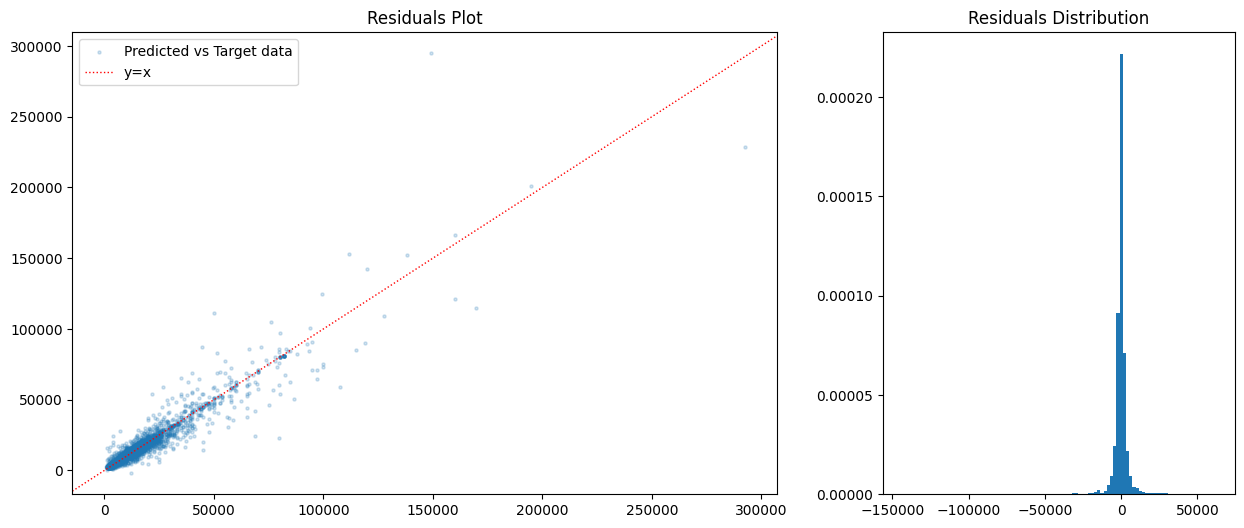

In [122]:
lgbm_reg = lgbm.train(params=study.best_params, train_set=lgbm_train)
y_pred = lgbm_reg.predict(X_test)
evaluate_model(y_test, y_pred, res_plot=True)

Feature Importance

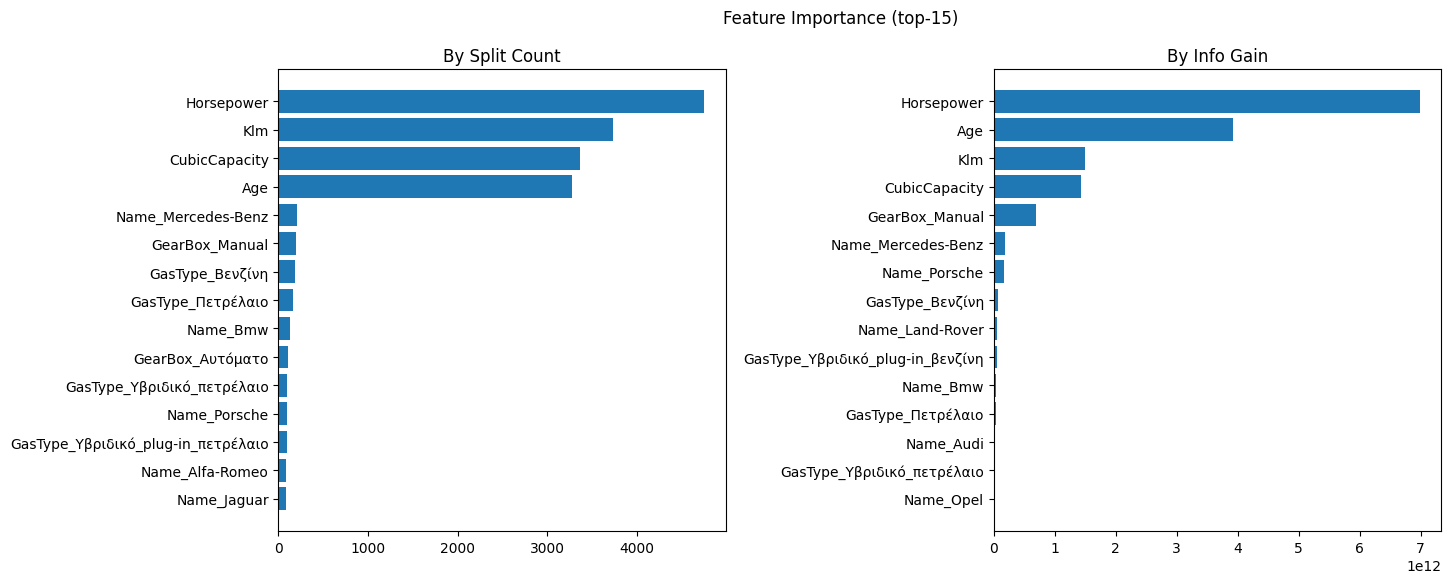

In [120]:
f_import_split = pd.DataFrame(data=lgbm_reg.feature_importance('split'), index=lgbm_reg.feature_name(), columns=['Feature_Importance'])
f_import_split = f_import_split.sort_values(by='Feature_Importance', ascending=False)

f_import_gain = pd.DataFrame(data=lgbm_reg.feature_importance('gain'), index=lgbm_reg.feature_name(), columns=['Feature_Importance'])
f_import_gain = f_import_gain.sort_values(by='Feature_Importance', ascending=False)

n = 15

f_import_split = f_import_split.iloc[:n]
f_import_gain = f_import_gain.iloc[:n]

fig, ax = plt.subplots(1, 2, figsize=(15,6), gridspec_kw={'wspace' : 0.6})

ax[0].barh(y=f_import_split.index, width=f_import_split['Feature_Importance'])
ax[0].set_title('By Split Count')
ax[0].invert_yaxis()

ax[1].barh(y=f_import_gain.index, width=f_import_gain['Feature_Importance'])
ax[1].set_title('By Info Gain')
ax[1].invert_yaxis()

plt.suptitle(f'Feature Importance (top-{n})')
plt.show()

### XGBoost [TO DO]

### CatBoost [TO DO]

### SHAP values [TO DO]